In [1]:
import matplotlib.pyplot as plt
import os 
import numpy as np
import re

In [2]:
'''
configure which experiments to load by
 choosing an experiment category from:          
    - "training_duration"                     
    - "reward_function_plus"                  
    - "reward_function"                       
    - "agent_config"
 and a run_id from 1,2,3
'''

############################
experiment_category = "reward_function"
run_id = "1"
############################

EXPERIMENT_CATEGORY = "../../data/experiments_" + experiment_category
EXPERIMENT_RUN = "_run_"+ run_id +  "/" 
constraintList = []

if experiment_category == "training_duration":
    constraintList = [[20,"eps-20-", "lr-0.01"], [20,"eps-20-", "lr-0.001"], [100,"eps-100","lr-0.001"],[100, "eps-100","lr-0.01"],[200,"eps-200","lr-0.001"],[200,"eps-200","lr-0.01"]]
elif experiment_category == "reward_function":
    constraintList = [[100,"mayer-"],[100,"mayer_-_100_-5"], [100,"mayer_-_10000_-5"], [100,"mayer_-_10000_-25"]] 
elif experiment_category == "reward_function_plus":
    constraintList= [[100,"mayer-"],[100,"mayer_-_100_-5"], [100,"mayer_-_10000_-5"], [100,"mayer_-_10000_-25"]] 
elif experiment_category == "agent_config":
    constraintList = [[100,"ppo"], [100,"ddqn"]] 


In [3]:
def load_experiments():
#load all experiments in different categories following constraint List
    fileList = []
    allExperiments = []
    fileNamesList = os.listdir(EXPERIMENT_CATEGORY + EXPERIMENT_RUN)
    for fileName in fileNamesList:
            fileList.append(fileName)

    #remove files, that dont match constraint
    for constraintCombi in constraintList:
        firstValue = True
        fileListFiltered = fileList.copy()
        for searchString in constraintCombi:
            if firstValue: #the first value of the list is the length
                length = searchString
                firstValue = False 
                continue
            for file in fileList:
                if not searchString in file and file in fileListFiltered:
                    fileListFiltered.remove(file)


        #load data as numpy
        #create name list as wellb
        currentExperiment = np.zeros((1,8,length))
        list_of_names = []
        for filename in fileListFiltered:
            list_of_names.append(filename)
            #convert data to helpful list of strings
            with open(EXPERIMENT_CATEGORY + EXPERIMENT_RUN + filename + '/results.txt', 'r') as file:
                data = file.read() 
                data = data.replace( "=[", "")
                data = data.replace( "]", "")
                identifier = ["returns","totalSteps","validActions", "totalTime","Evaluation"]
                for item in identifier: 
                    data = data.replace(item, "")
            
            data = data.splitlines()

            
            #convert read file to to np
            results = np.zeros((1,length))
            for line in data:
                newline = line.split(",")
                line = np.asarray(newline)
                line = line.astype(float)
                if len(line) < length:
                    fillerArray = np.zeros((1,(length-len(line))), dtype=float)
                    line = np.append(line,fillerArray)
                results = np.vstack([results,line])

            results = results[1:]
            results = results[np.newaxis,:]
            
            currentExperiment = np.vstack([currentExperiment,results])

        
        currentExperiment = currentExperiment[1:]
        allExperiments.append((currentExperiment,list_of_names,length))

    #plt.show()
    return allExperiments

In [4]:

allExperiments = load_experiments()


In [5]:
def plot_all_trends(allExperiments, info_to_plot, type, title, currentConstraint):
#plots all trend lines of one type (return, validAction etc)
    index = 0
    

    if info_to_plot == "returns":
        index = 0
    elif info_to_plot == "totalSteps":
        index = 1
    elif info_to_plot == "validActions":
        index = 2
    elif info_to_plot == "totalTime":
        index = 3

    
    if type=="evaluation":
        string_add_on = "Evaluation" 
        index += 4

    for i,currentConstraint in zip(range(0,len(allExperiments)),constraintList):
        x = range(0,allExperiments[i][2])
        y = np.sum(allExperiments[i][0], axis=0)[index]/len(allExperiments[i][0])

        
        trend_returns = np.polyfit(x, y, 2)
        trend_returns = np.poly1d(trend_returns)
        
        plt.plot(x,trend_returns(x), label=currentConstraint[1:]) 
        
    lgd = plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.6))
    plt.xlabel("episodes")
    plt.ylabel(info_to_plot)
    plt.title(title + "\n")
    plt.show()


    


In [6]:
def plot_one_trend(allExperiments, info_to_plot, type, title, currentConstraint):
#plots one trend
    index = 0
    

    if info_to_plot == "returns":
        index = 0
    elif info_to_plot == "totalSteps":
        index = 1
    elif info_to_plot == "validActions":
        index = 2
    elif info_to_plot == "totalTime":
        index = 3

    
    if type=="evaluation":
        string_add_on = "Evaluation" 
        index += 4

    x = range(0,allExperiments[2])
    y = np.sum(allExperiments[0], axis=0)[index]/len(allExperiments[0])
    

    trend_returns = np.polyfit(x, y, 2)
    trend_returns = np.poly1d(trend_returns)
    
    plt.plot(x,trend_returns(x), "k--", label=currentConstraint[1:]) 

    for i in range(0,len(allExperiments[0])):
        print("first:",allExperiments[0][i][index][0],"last",allExperiments[0][i][index][-1])
        #print("last10",allExperiments[0][i][index][-10:])
        
        plt.plot(x,allExperiments[0][i][index], label=allExperiments[1][i])
        print("avg:", np.mean(allExperiments[0][i][index]))    
    #print("avg_first:", y[0],"avg_last", y[-1])    
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.6))

    plt.xlabel("episodes")
    plt.ylabel(info_to_plot)
    plt.title(title + "\n")
    plt.show()


    


In [7]:
def plot_four_subplots(currentExperiment, type, title, currentConstraint):
#plots all four KPIs
    plt.figure(figsize=(10,7))
    
    for info_to_plot,j in zip(["totalTime", "returns", "totalSteps", "validActions"],range(1,5)):
        
        currentGraph = plt.subplot(2,2,j)
        index = 0
        if info_to_plot == "returns":
            index = 0
        elif info_to_plot == "totalSteps":
            index = 1
        elif info_to_plot == "validActions":
            index = 2
        elif info_to_plot == "totalTime":
            index = 3

        if type=="evaluation":
            string_add_on = "Evaluation" 
            index += 4


        x = range(0,currentExperiment[2])
        y = np.sum(currentExperiment[0], axis=0)[index]/len(currentExperiment[0])
        

        trend_returns = np.polyfit(x, y, 2)
        trend_returns = np.poly1d(trend_returns)
        
        plt.plot(x,trend_returns(x), "k--", label=currentConstraint[1:]) 

        for i in range(0,len(currentExperiment[0])):
            
            print(info_to_plot,": first:",currentExperiment[0][i][index][0],"last:",currentExperiment[0][i][index][-1], \
                "avg:", np.mean(currentExperiment[0][i][index]) )
            #print("last10",currentExperiment[0][i][index][-10:])

            plt.plot(x,currentExperiment[0][i][index], label=currentExperiment[1][i])
            print("---")
            
        #if info_to_plot == "totalSteps":
        #    currentGraph.set_ylim([0,5000])
        plt.xlabel("episodes")
        plt.ylabel(info_to_plot)

        #if info_to_plot == "returns":
        #    currentGraph.set_ylim([-12000,8000])


    plt.title(title + "\n")
    plt.tight_layout()
    plt.legend(loc="lower center", bbox_to_anchor=(-0.1, -0.65))
    plt.show()


    


In [8]:
'''
Now depending on what you want to analyse, you can plot different information: 
- plot_all_trends > plots all trend lines (as defined in constraintList), you can choose if you want to plot the training or the evaluation and which KPI (returns, totalTime, validActions, totalSteps)
    example: 
    plot_all_trends(allExperiments=allExperiments,info_to_plot="returns",type="training", title="CHOOSE TITLE", currentConstraint=constraintList)
- plot_one_trend > plots a chosen trend and its underlying experiments, you can choose: training of evaluation, which KPI, which trend
    example: 
    plot_one_trend(allExperiments=allExperiments[0],info_to_plot="returns",type="training", title="CHOOSE TITLE",currentConstraint=constraintList[0])
-  plot_four_subplots > plots all four kpis as a minipage to keep better overview of interdependence also shows avg and start/last values, choose from kpi, training or evaluation and exp_id
    example:    
    plot_four_subplots(currentExperiment=allExperiments[0],type="training", title="CHOOSE TITLE", currentConstraint=constraintList[0])


'''

'\nNow depending on what you want to analyse, you can plot different information: \n- plot_all_trends > plots all trend lines (as defined in constraintList), you can choose if you want to plot the training or the evaluation and which KPI (returns, totalTime, validActions, totalSteps)\n    example: \n    plot_all_trends(allExperiments=allExperiments,info_to_plot="returns",type="training", title="CHOOSE TITLE", currentConstraint=constraintList)\n- plot_one_trend > plots a chosen trend and its underlying experiments, you can choose: training of evaluation, which KPI, which trend\n    example: \n    plot_one_trend(allExperiments=allExperiments[0],info_to_plot="returns",type="training", title="CHOOSE TITLE",currentConstraint=constraintList[0])\n-  plot_four_subplots > plots all four kpis as a minipage to keep better overview of interdependence also shows avg and start/last values, choose from kpi, training or evaluation and exp_id\n    example:    \n    plot_four_subplots(currentExperiment=

TypeError: unsupported operand type(s) for +: 'type' and 'str'

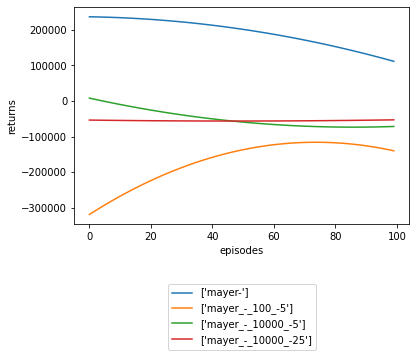

In [9]:
### Plot all trends for every KPI for training and evaluation
plot_all_trends(allExperiments=allExperiments,info_to_plot="returns",type=type, title=type, currentConstraint=constraintList)



#for kpi in {"returns", "totalTime", "validActions", "totalSteps"}:
#    for type in {"training", "evaluation"}:
#        plot_all_trends(allExperiments=allExperiments,info_to_plot=kpi,type=type, title=type, currentConstraint=constraintList)

first: 220415.0 last 210819.0
avg: 195575.38
first: -84159.0 last 244976.0
avg: 126646.46


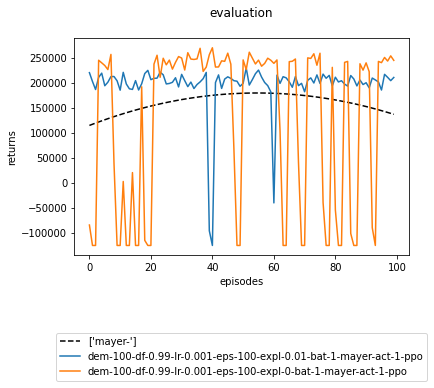

In [ ]:
### Plot all trends for every KPI for training and evaluation
plot_one_trend(allExperiments=allExperiments[0],info_to_plot="returns",type=type, title=type, currentConstraint=constraintList[0])

#for kpi in {"returns", "totalTime", "validActions", "totalSteps"}:
#    for type in {"training", "evaluation"}:
#        for exp_id in range(0,len(constraintList)):
#            plot_one_trend(allExperiments=allExperiments[exp_id],info_to_plot=kpi,type=type, title=type, currentConstraint=constraintList[exp_id])

totalTime : first: 146232.0 last: 120156.0 avg: 119919.24
---
totalTime : first: 145332.0 last: 122400.0 avg: 125829.6
---
returns : first: 254280.0 last: 206531.0 avg: 198018.78
---
returns : first: 255813.0 last: 54793.0 avg: 187453.26
---
totalSteps : first: 2418.0 last: 2080.0 avg: 3381.12
---
totalSteps : first: 2371.0 last: 25000.0 avg: 5163.71
---
validActions : first: 352.0 last: 358.0 avg: 335.5
---
validActions : first: 353.0 last: 287.0 avg: 318.67
---


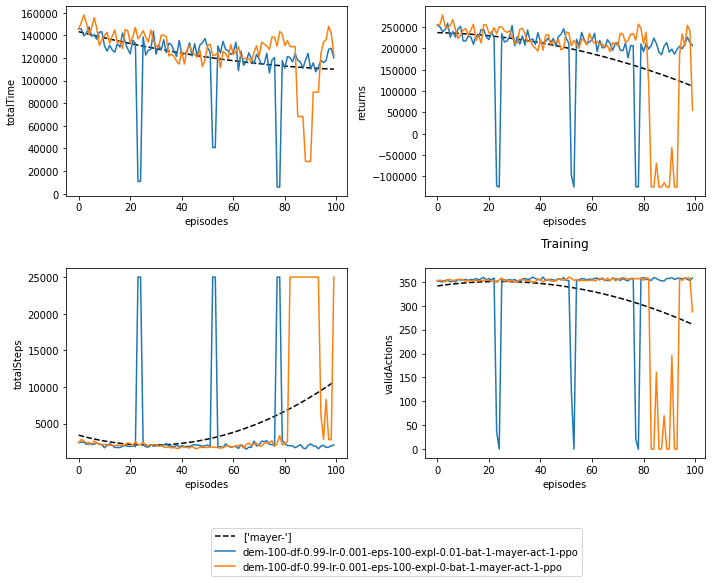

In [ ]:
plot_four_subplots(currentExperiment=allExperiments[0],type="training", title="Training", currentConstraint=constraintList[0])


#title = ""
#for i in range(0,len(constraintList)):
#    plot_four_subplots(currentExperiment=allExperiments[i],type="training", title=title, currentConstraint=constraintList[i])
#    plot_four_subplots(currentExperiment=allExperiments[i],type="evaluation", title=title, currentConstraint=constraintList[i])

